# Introduction to PyCBA

PyCBA (Python Continuous Beam Analysis) is a general linear elastic one-dimensional beam analysis package.

This introduction demonstrates the basic use of `PyCBA` and results that can be obtained. So let's get started...

In [1]:
# Basic imports
import pycba as cba  # The main package
import numpy as np  # For arrays
import matplotlib.pyplot as plt  # For plotting
from IPython import display  # For images in this notebook

## Example 1 - Basic Analysis
Analyse a two span beam, with a UDL of 20 kN/m on each span

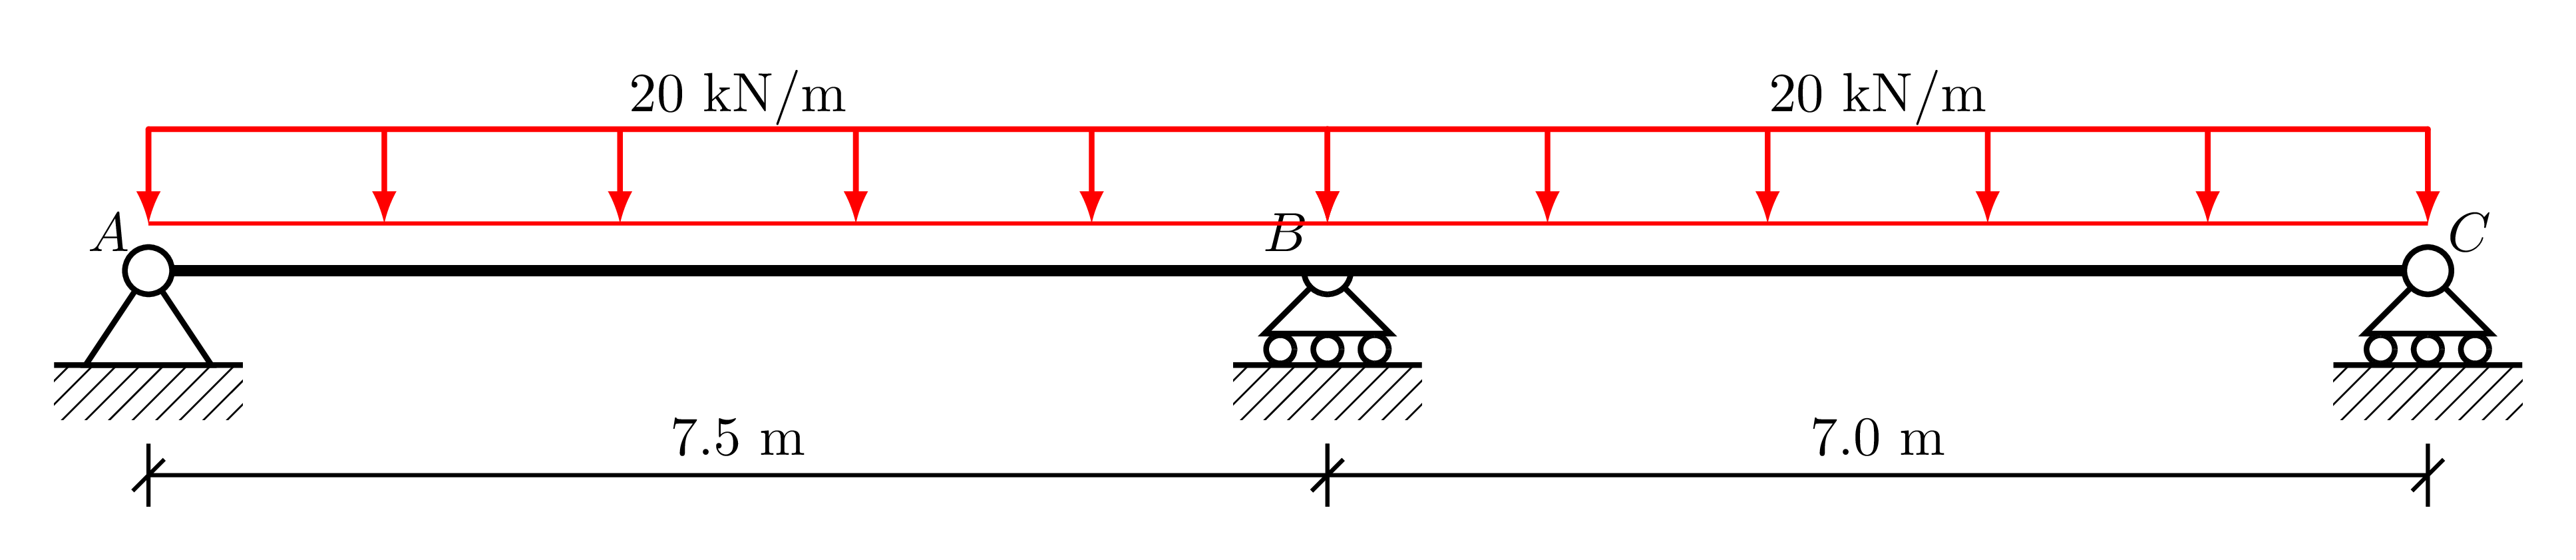

In [2]:
display.Image("./images/intro_ex_1.png",width=800)

Here is the specification for `PyCBA`, explained below:

In [3]:
L = [7.5, 7.0]
EI = 30 * 600e7 * 1e-6
R = [-1, 0, -1, 0, -1, 0]

Initially, we define the member lengths, which in this case coincides with the spans, $AB$, and $BC$. 

The flexural rigidity (elastic modulus multiplied by the second moment of area) can be defined for each member, or if a scalar value is passed, this is assigned to all members. Here we take $E = 30$ GPa and $I = 600 \times 10^7$ mm$^4$, and apply a conversion to put it into a consistent set of units (kN and m).

The beam restraints at each nodal degree of freedom are then defined. Since there are three nodes, this will be a vector of $2 \times 3 = 6$ entries. Only the vertical (and not rotational) degree of freedom is restrained at nodes $A$, $B$, and $C$, and so this is indicated using $-1$ and $0$ for unrestrained.

With the basic variables defined, we construct the `beam_analysis` object by passing these variables.

In [4]:
beam_analysis = cba.BeamAnalysis(L, EI, R)

Next, we add the loads for each span to this object using the `add_*` utility functions:

In [5]:
beam_analysis.add_udl(i_span=1,w=20)
beam_analysis.add_udl(i_span=2,w=20)

Now that we have applied the loads, it is ready for analysis and we call the `analyze()` function and plot the results:

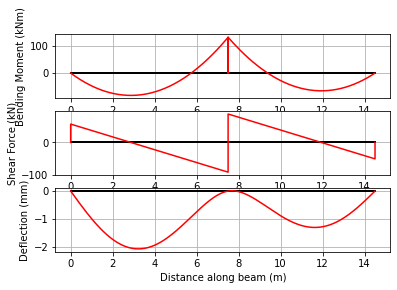

In [6]:
beam_analysis.analyze()
beam_analysis.plot_results()

The numerical results can found from the `beam_results` member of `beam_analysis` object.

For example, the reactions corresponding to the fully-restrained nodes are:

In [7]:
beam_analysis.beam_results.R

array([ 57.41666667, 181.42261905,  51.16071429])

and the maximum bending moment along the second member, $BC$, can be got from:

In [8]:
beam_analysis.beam_results.vRes[1].M.max()

65.42525

Since we have been consistent with our units, the reactions are in kN and the bending moment in kNm.

## Example 2 - Load Definitions

In this example, we consider a two-span beam with a fixed remote end, more load types, and a lower-level method for defining loads. 

In addition to the utility functions for adding loads, a "load matrix" can be defined directly. This is a list of loads, where each load is defined by a list of five numbers, as defined in the docs:
```
Span No. | Load Type | Load Value | Distance a | Load Cover c
```
For UDLs covering the full length of the member, only the span number, load type, and value have non-zero entries.

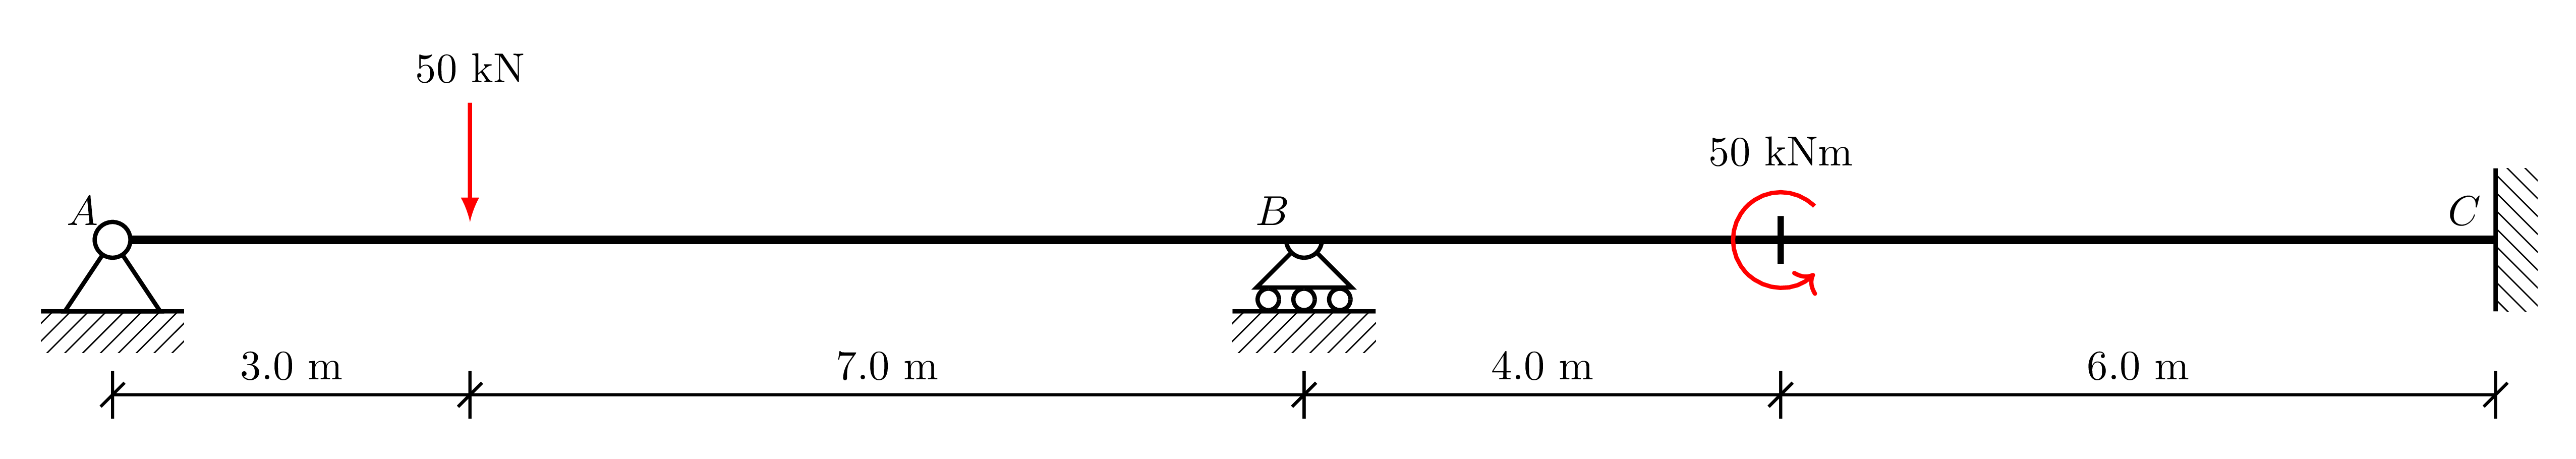

In [9]:
display.Image("./images/intro_ex_2.png",width=800)

With two loads the *load matrix* (see `pycba.load`) is a list of two lists:

- Span 1: point load is load type 2, with a value of $50$ kN, at $a = 3$ m
- Span 2: moment load is load type 4, anti-clockwise positive $50$ kNm, at $a = 4$ m

Note, also that node $C$ will have its two degrees of freedom restrained.

In [10]:
L = [10.0, 10.0]
EI = 30 * 600e7 * 1e-6  # kNm2
R = [-1, 0, -1, 0, -1, -1]
LM = [[1, 2, 50, 3, 0], [2, 4, 50, 4, 0]]

Along with `L`, `EI`, and `R`, the load matrix `LM` can be directly passed to the `BeamAnalysis` constructor resulting in an object ready for analysis. And to better evaluate the discontinuities for the moment and point loads, we can increase the number of evaluation points along each member to 500 when calling `analyze()` as follows:

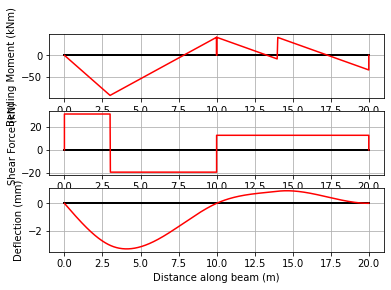

In [11]:
beam_analysis = cba.BeamAnalysis(L, EI, R, LM)
beam_analysis.analyze(500)
beam_analysis.plot_results()

## Example 3 - 3-span beam in a building subframe
In this example we consider a reinforced concrete building subframe in which the columns are 4 m high, and 300 mm square. We take $E=30$ GPa Hence the roational stiffness at each joint is $2 \times (4EI)/L$ giving

$$
k = 2\times \frac{4\times30\times(300^4)}{4000} \times 10^3 = 486\times10^9\ \textrm{kNm/rad}
$$

We also take the beam as $300\times600$ giving

$$
I = \frac{300\times 600^3}{12} = 5.4\times10^9\ \textrm{mm}^4
$$

So we can define the beam now as usual:

In [12]:
L = [6,8,6]
E = 30
I = [54e8,54e8,54e8]
R = [-1,486e9,-1,486e9,-1,486e9,-1,486e9]

In [13]:
beam_analysis = cba.BeamAnalysis(L, EI, R)

Next, we add the loads for each span:

In [14]:
beam_analysis.add_udl(i_span=1,w=10)
beam_analysis.add_udl(i_span=2,w=20)
beam_analysis.add_udl(i_span=3,w=10)

Now we can analyze and plot the results:

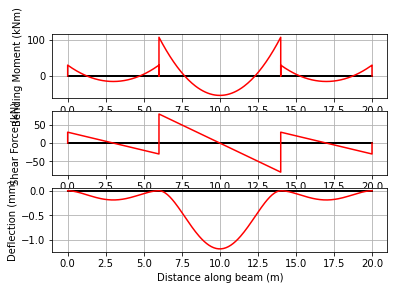

In [15]:
beam_analysis.analyze()
beam_analysis.plot_results()

The influence of the column rotational stiffness at the joints is clear, and the moments in the columns canbe found as the difference in the moments at the ends of the connecting spans.

## Example 4 - Post-tensioned 4-span beam
In this example, we determine the load effects applied by a post-tensioned cable. We define the load matrix directly, based on the geometry of the cable drape.

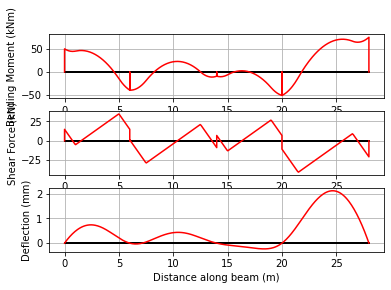

In [16]:
L = [6,8,6,8]
E = 30
I = [100e8,100e8,100e8,100e8]
R = [-1,0,-1,0,-1,0,-1,0,-1,0]
LM = [[1,4,50,0,0],     # eccentricity at end
      [1,3,20,0,1],     # convex drape for 1 m
      [1,3,-10,1,4],    # concave drape for 4 m
      [1,3,20,5,1],     # convex drape for 1 m
      [2,3,20,0,1.5],   # convex drape for 1.5 m
      [2,3,-10,1.5,5],  # concave drape for 5 m
      [2,3,20,6.5,1.5], # convex drape for 1.5 m
      [3,3,20,0,1],     # convex drape for 1 m
      [3,3,-10,1,4],    # concave drape for 4 m
      [3,3,20,5,1],     # convex drape for 1 m
      [4,3,20,0,1.5],   # convex drape for 1.5 m
      [4,3,-10,1.5,5],  # concave drape for 5 m
      [4,3,20,6.5,1.5], # convex drape for 1.5 m
      [4,4,-75,8,0]]    # eccentricity at end
beam_analysis = cba.BeamAnalysis(L, EI, R, LM)
beam_analysis.analyze()
beam_analysis.plot_results()

## Example 5 - Superposition for load-balancing
Using the `add_LM` subroutine load matrices may be superimposed. Based on Example 4, we will define the service loads and then the prestress equivalent loads are added. Both load cases are analysed seperately and the combined LM analysed: each set of results are displayed seperately.

Define the beam as before:

In [17]:
L = [6,8,6,8]
E = 30
I = [100e8,100e8,100e8,100e8]
R = [-1,0,-1,0,-1,0,-1,0,-1,0]
beam_analysis = cba.BeamAnalysis(L, EI, R)

And now define the dead loads `LMg`, the live loads `LMq`, and the prestress loads as before `LMp`

In [18]:
LMg = [[1,1,20,0,0],    # 20 kN/m on each span
       [2,1,20,0,0],
       [3,1,20,0,0],
       [4,1,20,0,0]]
LMq = [[1,1,30,0,0],    # 30 kN/m on each span
       [2,1,30,0,0],
       [3,1,30,0,0],
       [4,1,30,0,0]]
LMp = [[1,4,50,0,0],    # eccentricity at end
      [1,3,20,0,1],     # convex drape for 1 m
      [1,3,-10,1,4],    # concave drape for 4 m
      [1,3,20,5,1],     # convex drape for 1 m
      [2,3,20,0,1.5],   # convex drape for 1.5 m
      [2,3,-10,1.5,5],  # concave drape for 5 m
      [2,3,20,6.5,1.5], # convex drape for 1.5 m
      [3,3,20,0,1],     # convex drape for 1 m
      [3,3,-10,1,4],    # concave drape for 4 m
      [3,3,20,5,1],     # convex drape for 1 m
      [4,3,20,0,1.5],   # convex drape for 1.5 m
      [4,3,-10,1.5,5],  # concave drape for 5 m
      [4,3,20,6.5,1.5], # convex drape for 1.5 m
      [4,4,-75,8,0]]    # eccentricity at end

The loadings at transfer are then obtained by superposition (`add_LM`), the superimposed loads are applied to the beam (`set_loads`), and analyzed:

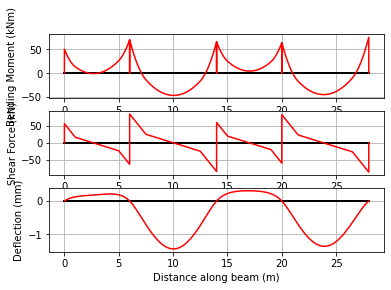

In [19]:
LMt = cba.add_LM(LMg,LMp)
beam_analysis.set_loads(LMt)
out_t = beam_analysis.analyze()
beam_analysis.plot_results()

The service load effects are then calculated by further superposition of the live loads onto the transfer loads. We reset the loads in the `beam_analysis` object and re-analyze:

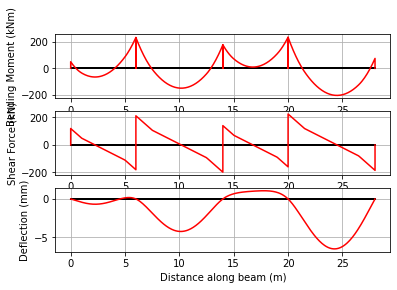

In [20]:
LMs = cba.add_LM(LMt,LMq)
beam_analysis.set_loads(LMs)
out_s = beam_analysis.analyze()
beam_analysis.plot_results()